# Распознавание марок машин

*Добейтесь точности не менее 85% на проверочной выборке на базе трех иномарок.*

Размер проверочной выборки - 20%.

In [1]:
import logging
from pathlib import Path
from typing import Optional

import numpy as np

import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.callbacks import History
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,  
    Dropout, 
    Flatten,
    MaxPooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from PIL import Image 

from matplotlib import pyplot as plt
%matplotlib inline

Установить уровень диагностических сообщений для TensorFlow.

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

Отобразить список доступных устройств.

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Задать количество эпох для обучения.

In [4]:
EPOCHS = 45

Задать размер пакета.

In [5]:
BATCH_SIZE = 25

Определить размеры изображения.

In [6]:
IMG_WIDTH = 96  # Ширина изображения
IMG_HEIGHT = 54  # Высота изображения

Определить вспомогательную функцию для визуализации процесса обучения.

In [7]:
def plot_history(
    history: History, 
    title: str, 
    axes: Optional[np.ndarray] = None
) -> None:
    if axes is None or not axes.all():
        _, axes = plt.subplots(1, 2, figsize=(12, 5))
        show_plot = True
    else:
        show_plot = False

    axes[0].plot(
        history.epoch,
        history.history['loss'],
        color='steelblue',
        label='train set'
    )
    axes[0].plot(
        history.epoch,
        history.history['val_loss'],
        color='darkblue',
        label='validation set'
    )
    axes[0].set_title(f"{title} (изменение loss)")
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[0].set_xticks(range(0, len(history.epoch) + 1, 5))
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(
        history.epoch,
        history.history['accuracy'],
        color='salmon',
        label='train set'
    )
    axes[1].plot(
        history.epoch,
        history.history['val_accuracy'],
        color='darkred',
        label='validation set'
    )
    axes[1].set_title(f"{title} (изменение accuracy)")
    axes[1].set_ylabel('accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].set_xticks(range(0, len(history.epoch) + 1, 5))
    axes[1].grid(True)
    axes[1].legend()

    if show_plot:
        plt.show()

Задать путь для сохранения моделей нейронных сетей.

In [8]:
out_path = Path.home() / 'aiu-03-cars-ultra-pro-models'
if not out_path.exists():
    Path.mkdir(out_path, parents=True)

## Подготовка данных

Определить путь к набору данных.

In [9]:
root_path = Path.cwd().parent.parent / 'data' / 'images' / '03-cars'

Создать генератор изображений:

In [10]:
datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range=10, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    zoom_range=0.1, 
    horizontal_flip=True, 
    fill_mode='nearest', 
    validation_split=0.2
)

Определить генераторы для обучающей и проверочной выборок.

In [11]:
# Обучающая выборка
train_generator = datagen.flow_from_directory(
    root_path / 'train',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE, 
    class_mode='categorical',
    shuffle=True, 
    subset='training'
)

# Проверочная выборка
validation_generator = datagen.flow_from_directory(
    root_path / 'train', 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    shuffle=True, 
    subset='validation' 
)

Found 2196 images belonging to 3 classes.
Found 547 images belonging to 3 classes.


Определить генератор для тестовой выборки.

In [12]:
# Тестовая выборка
test_generator = datagen.flow_from_directory(
    root_path / 'val', 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    shuffle=True, 
    subset='validation' 
)

Found 136 images belonging to 3 classes.


Вывести для примера изображения по каждому классу.

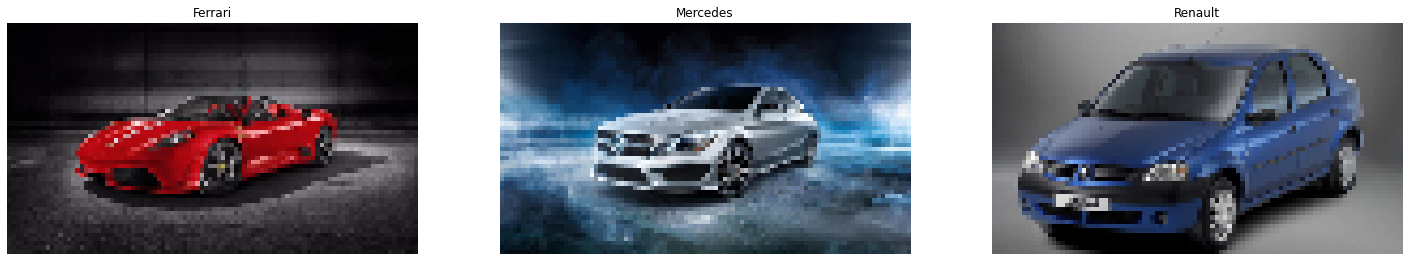

In [13]:
_, axes = plt.subplots(1, 3, figsize=(25, 5))

classes = set()
plot_number = 0
for i in (root_path / 'train').glob('**/*'):
    img_path = i.absolute()
    if not img_path.is_file():
        continue

    class_name = img_path.parent.name

    if class_name not in classes:
        classes.add(class_name)

        axes[plot_number].imshow(
            image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        )
        axes[plot_number].set_title(class_name)
        axes[plot_number].set_axis_off()

        plot_number += 1
    else:
        continue

plt.show();

## Создание и обучение эталонной модели сверточной нейронной сети

Создать и скомпилировать эталонную модель.

In [14]:
reference_net = Sequential()

reference_net.add(
    Conv2D(
        256, 
        (3, 3), 
        padding='same', 
        activation='relu', 
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
    )
)
reference_net.add(
    Conv2D(
        256, 
        (3, 3), 
        padding='same', 
        activation='relu'
    )
)
reference_net.add(MaxPooling2D(pool_size=(3, 3)))

reference_net.add(
    Conv2D(
        256, 
        (3, 3), 
        padding='same', 
        activation='relu'
    )
)
reference_net.add(Dropout(0.2))

reference_net.add(
    Conv2D(
        256, 
        (3, 3), 
        padding='same', 
        activation='relu'
    )
)
reference_net.add(MaxPooling2D(pool_size=(3, 3)))
reference_net.add(Dropout(0.2))

reference_net.add(
    Conv2D(
        512, 
        (3, 3), 
        padding='same', 
        activation='relu'
    )
)

reference_net.add(
    Conv2D(
        1024, 
        (3, 3), 
        padding='same', 
        activation='relu'
    )
)
reference_net.add(MaxPooling2D(pool_size=(3, 3)))
reference_net.add(Dropout(0.2))
 
reference_net.add(Flatten())
reference_net.add(Dense(2048, activation='relu'))
reference_net.add(Dense(4096, activation='relu'))
reference_net.add(
    Dense(
        len(train_generator.class_indices), 
        activation='softmax'
    )
)

reference_net.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(lr=0.0001), 
    metrics=['accuracy']
)
print(reference_net.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 54, 256)       7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 54, 256)       590080    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 18, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 18, 256)       590080    
_________________________________________________________________
dropout (Dropout)            (None, 32, 18, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 18, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 6, 256)        0

Обучить нейронную сеть.

In [15]:
history = reference_net.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/45
87/87 [==============================] - 7s 84ms/step - loss: 1.0229 - accuracy: 0.4592 - val_loss: 0.9051 - val_accuracy: 0.5486
Epoch 2/45
87/87 [==============================] - 7s 76ms/step - loss: 0.9184 - accuracy: 0.5398 - val_loss: 0.8981 - val_accuracy: 0.5543
Epoch 3/45
87/87 [==============================] - 7s 76ms/step - loss: 0.8928 - accuracy: 0.5596 - val_loss: 0.8908 - val_accuracy: 0.5714
Epoch 4/45
87/87 [==============================] - 7s 75ms/step - loss: 0.8680 - accuracy: 0.5753 - val_loss: 0.8436 - val_accuracy: 0.6171
Epoch 5/45
87/87 [==============================] - 7s 75ms/step - loss: 0.8376 - accuracy: 0.5910 - val_loss: 0.8452 - val_accuracy: 0.6400
Epoch 6/45
87/87 [==============================] - 7s 76ms/step - loss: 0.8066 - accuracy: 0.6099 - val_loss: 0.8012 - val_accuracy: 0.6229
Epoch 7/45
87/87 [==============================] - 7s 77ms/step - loss: 0.7968 - accuracy: 0.6269 - val_loss: 0.7454 - val_accuracy: 0.6762
Epoch 8/45
87

Отобразить прогресс обучения нейронной сети.

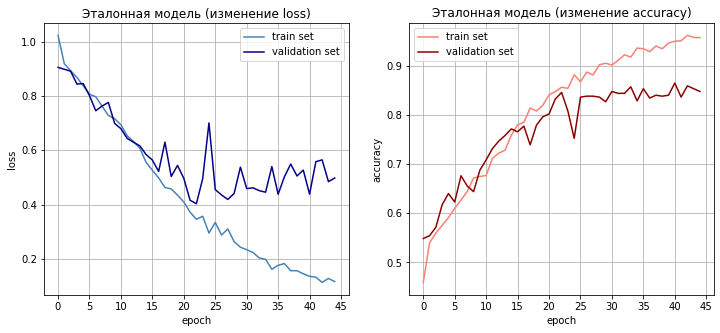

In [16]:
plot_history(history, "Эталонная модель")

Сохранить архитектуру нейронной сети.

In [17]:
reference_net.save(out_path / 'aiu-03-cars-ultra-pro-model-reference')

Получить значения loss и accuracy для тестовой выборки.

In [18]:
score = reference_net.evaluate(test_generator, verbose=0)

print(f"Test loss: {score[0]:.5f}\nTest accuracy: {score[1]:.5f}")

Test loss: 0.52744
Test accuracy: 0.82353


## Создание и обучение сверточной сети с требуемыми характеристиками

Создать и скомпилировать модель.

In [19]:
net = Sequential()

net.add(BatchNormalization(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
net.add(
    Conv2D(
        256, 
        (3, 3), 
        padding='same', 
        activation='relu', 
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
    )
)
net.add(
    Conv2D(
        256, 
        (3, 3), 
        padding='same', 
        activation='relu'
    )
)
net.add(MaxPooling2D(pool_size=(3, 3)))

net.add(BatchNormalization())
net.add(
    Conv2D(
        256, 
        (3, 3), 
        padding='same', 
        activation='relu'
    )
)
net.add(Dropout(0.2))

net.add(
    Conv2D(
        256, 
        (3, 3), 
        padding='same', 
        activation='relu'
    )
)
net.add(MaxPooling2D(pool_size=(3, 3)))
net.add(Dropout(0.2))

net.add(
    Conv2D(
        512, 
        (3, 3), 
        padding='same', 
        activation='relu'
    )
)

net.add(
    Conv2D(
        2048, 
        (3, 3), 
        padding='same', 
        activation='relu'
    )
)
net.add(MaxPooling2D(pool_size=(3, 3)))
net.add(Dropout(0.2))
 
net.add(Flatten())
net.add(Dense(2048, activation='relu'))
net.add(Dropout(0.2))
net.add(Dense(4096, activation='relu'))
net.add(Dropout(0.2))
net.add(
    Dense(
        len(train_generator.class_indices), 
        activation='softmax'
    )
)

net.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(lr=0.0001), 
    metrics=['accuracy']
)
print(net.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 96, 54, 3)         12        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 96, 54, 256)       7168      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 54, 256)       590080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 18, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 18, 256)       1024      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 18, 256)       590080    
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 18, 256)      

Обучить нейронную сеть.

In [20]:
history = net.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/45
87/87 [==============================] - 8s 93ms/step - loss: 1.0010 - accuracy: 0.4758 - val_loss: 1.0870 - val_accuracy: 0.5448
Epoch 2/45
87/87 [==============================] - 8s 90ms/step - loss: 0.8800 - accuracy: 0.5675 - val_loss: 1.0657 - val_accuracy: 0.5943
Epoch 3/45
87/87 [==============================] - 8s 88ms/step - loss: 0.8252 - accuracy: 0.6085 - val_loss: 0.9766 - val_accuracy: 0.6533
Epoch 4/45
87/87 [==============================] - 8s 89ms/step - loss: 0.7778 - accuracy: 0.6421 - val_loss: 0.9479 - val_accuracy: 0.5771
Epoch 5/45
87/87 [==============================] - 8s 90ms/step - loss: 0.7604 - accuracy: 0.6490 - val_loss: 0.8474 - val_accuracy: 0.6171
Epoch 6/45
87/87 [==============================] - 8s 91ms/step - loss: 0.7047 - accuracy: 0.6771 - val_loss: 0.8160 - val_accuracy: 0.6076
Epoch 7/45
87/87 [==============================] - 8s 92ms/step - loss: 0.6662 - accuracy: 0.7089 - val_loss: 0.8188 - val_accuracy: 0.6095
Epoch 8/45
87

Отобразить прогресс обучения нейронной сети.

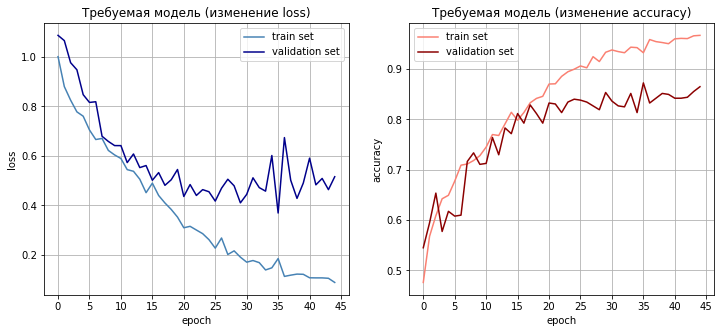

In [21]:
plot_history(history, "Требуемая модель")

Сохранить архитектуру нейронной сети.

In [22]:
net.save(out_path / 'aiu-03-cars-ultra-pro-model')

Получить значения loss и accuracy для тестовой выборки.

In [23]:
score = net.evaluate(test_generator, verbose=0)

print(f"Test loss: {score[0]:.5f}\nTest accuracy: {score[1]:.5f}")

Test loss: 0.91873
Test accuracy: 0.77941


Таким образом, для проверочной выборки получено значение accuracy, большее 85%. Хотя для тестовой выборки оно примерно равно 78%, что служит сигналом для проведения дополнительных исследований по улучшению архитектуры сверточной нейронной сети.